# Water quality estimation

Using [MAGO](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/mago_water_quality_monitoring_tool/)

In [ ]:
from typing import Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np


def plot_image(
    image: np.ndarray,
    factor: float = 1.0,
    clip_range: Optional[Tuple[float, float]] = None,
    **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
!pip install sentinelhub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

## Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook.

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [ ]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

Enter your SentinelHub client id··········
Enter your SentinelHub client secret··········


However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `<profile_name>`.

In [ ]:
#config = SHConfig("cdse")

## Setting an area of interest

The bounding box in `WGS84` coordinate system is `[(longitude and latitude coordinates of lower left and upper right corners)]`. You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

All requests require a bounding box to be given as an instance of `sentinelhub.geometry.BBox` with corresponding Coordinate Reference System (`sentinelhub.constants.CRS`). In our case it is in WGS84 and we can use the predefined WGS84 coordinate reference system from `sentinelhub.constants.CRS`.

In [ ]:
# original example
#aoi_coords_wgs84 = [15.461282, 46.757161, 15.574922, 46.851514]

# muggelsee area
#aoi_coords_wgs84 = [13.552322, 52.399591, 13.799515, 52.485394]
aoi_coords_wgs84 = [13.614979,52.423674,13.688364,52.450779]

# krumme lanke and schlachtensee
#aoi_coords_wgs84 = [13.192606,52.435345,13.251143,52.457840]

# havel at spandau
#aoi_coords_wgs84 = [13.201876, 52.537683, 13.232775, 52.563934]

When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [ ]:
# TODO: decrease resolution to decrease image size

resolution = 10
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 10 m resolution: (504, 292) pixels


# Own analysis across years

In [ ]:
from datetime import date

def gen_year_summer(year: int):
    return (str(date(year, 5, 1)), str(date(year, 9, 1)))

year_list = list(range(2017, 2026))

summer_intervals = [gen_year_summer(year) for year in year_list]

In [ ]:
def flat_dropna(img):
  return img[~np.isnan(img)].flatten()

# Getting all metrics

In [ ]:
index_number = 0
min_value = 0
max_value = 30

evalscript_all_metrics = f"""
//VERSION=3
// ---- User params for visualization only ----
var indexNumber = {index_number}; // which index to visualize
var minValue = {min_value};
var maxValue = {max_value};
"""

# TODO: Is medium probability cloud or not?

evalscript_all_metrics += """
// ---- Color scale ----
var scaleLimits = [minValue, (maxValue + 3 * minValue) / 4, (maxValue + minValue) / 2, (3 * maxValue + minValue) / 4, maxValue];
var s = 255;
var colorScale = [
  [0/s, 0/s, 255/s],   // Blue
  [0/s, 255/s, 255/s], // Cyan
  [0/s, 255/s, 0/s],   // Green
  [255/s, 255/s, 0/s], // Yellow
  [255/s, 0/s, 0/s],   // Red
];

function setup() {
  return {
    input: ["B01","B02","B03","B04","B05","B06","B07","B08","SCL","dataMask"],
    output: [
      { id: "default",  bands: 3 },
      { id: "indices",  bands: 8, sampleType: "FLOAT32" }, // <- all index values here
      { id: "eobrowserStats", bands: 2, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 }
    ]
  };
}

function isCloud(scl) {
  if (scl == 3) return true;   // SC_CLOUD_SHADOWS
  if (scl == 9) return true;   // SC_CLOUD_HIGH_PROBABILITY
  if (scl == 8) return true;  // SC_CLOUD_MEDIUM_PROBABILITY
  if (scl == 7) return false;  // SC_UNCLASSIFIED
  if (scl == 10) return true;  // SC_THIN_CIRRUS
  if (scl == 11) return true;  // SC_SNOW_ICE
  if (scl == 1) return true;   // SC_SATURATED_OR_DEFECTIVE
  if (scl == 2) return false;  // SC_DARK_FEATURE_SHADOW
  return false;
}

function evaluatePixel(samples) {
  // Water mask (NDWI)
  let NDWI = index(samples.B03, samples.B08);

  // True color for viz (or NaN to hide non-water)
  let TrueColor = [samples.B04 * 2.5, samples.B03 * 2.5, samples.B02 * 2.5];
  let Hidden = [NaN, NaN, NaN];

  // ---- All indices (8) ----
  // 0 | Chl-a mg/m3 (Mishra 2012 – NDCI-based)
  let index0 = 14.039 + (86.11 * (samples.B05 - samples.B04) / (samples.B05 + samples.B04))
               + (194.325 * Math.pow((samples.B05 - samples.B04) / (samples.B05 + samples.B04), 2));

  // 1 | Chl-a > 5 mg/m3 (Soria-Perpinyà 2021)
  let index1 = 19.866 * Math.pow(samples.B05 / samples.B04, 2.3051);

  // 2 | Chl-a < 5 mg/m3 (Soria-Perpinyà 2021)
  let index2 = Math.pow(10, -2.4792 * Math.log10(Math.max(samples.B03, samples.B02) / samples.B03) - 0.0389);

  // 3 | Cyanobacteria (phycocyanin) cells/mL (Potes et al. 2018)
  let index3 = 115530.31 * Math.pow((samples.B03 * samples.B04) / samples.B02, 2.38);

  // 4 | Phycocyanin mg/m3 (Soria-Perpinyà 2021)
  let index4 = 21.554 * Math.pow((samples.B05 / samples.B04), 3.47941);

  // 5 | Turbidity NTU (Zhan et al. 2022)
  let index5 = 194.79 * (samples.B05 * (samples.B05 / samples.B02)) + 0.9061;

  // 6 | CDOM ug/L (Soria-Perpinyà 2021)
  let index6 = 2.4072 * (samples.B04 / samples.B02) + 0.0709;

  // 7 | TSS mg/L (Soria-Perpinyà 2021)
  let index7 = 14.464 * (samples.B07 / samples.B02) + 16.336;

  // Colorized versions for visualization
  let viz0 = colorBlend(index0, scaleLimits, colorScale);
  let viz1 = colorBlend(index1, scaleLimits, colorScale);
  let viz2 = colorBlend(index2, scaleLimits, colorScale);
  let viz3 = colorBlend(index3, scaleLimits, colorScale);
  let viz4 = colorBlend(index4, scaleLimits, colorScale);
  let viz5 = colorBlend(index5, scaleLimits, colorScale);
  let viz6 = colorBlend(index6, scaleLimits, colorScale);
  let viz7 = colorBlend(index7, scaleLimits, colorScale);

  // Choose which one to show (visualization only)
  let imgVals = TrueColor;
  let val = NaN;
  if (NDWI < 0) {
    // imgVals = Hidden; // hide non-water
    imgVals = TrueColor; // keep true color, not hiding non-water
  } else {
    switch (indexNumber) {
      // case 0: imgVals = viz0; val = index0; break;
      // case 1: imgVals = viz1; val = index1; break;
      // case 2: imgVals = viz2; val = index2; break;
      // case 3: imgVals = viz3; val = index3; break;
      // case 4: imgVals = viz4; val = index4; break;
      // case 5: imgVals = viz5; val = index5; break;
      // case 6: imgVals = viz6; val = index6; break;
      // case 7: imgVals = viz7; val = index7; break;
      // default: imgVals = TrueColor;
      //
      // alternative: imgVals always stays TrueColor
      case 0: val = index0; break;
      case 1: val = index1; break;
      case 2: val = index2; break;
      case 3: val = index3; break;
      case 4: val = index4; break;
      case 5: val = index5; break;
      case 6: val = index6; break;
      case 7: val = index7; break;
    }
  }

  // Indices output (mask with dataMask AND NDWI>=0); otherwise NaNs
  let validWater = samples.dataMask === 1 && NDWI >= 0;
  let allIndices = validWater
    ? [index0,index1,index2,index3,index4,index5,index6,index7]
    : new Array(8).fill(NaN);

  return {
    default: imgVals,
    indices: allIndices,
    eobrowserStats: [val, isCloud(samples.SCL) ? 1 : 0],
    dataMask: [samples.dataMask]
  };
}
"""

In [ ]:
summer_intervals = [gen_year_summer(year) for year in year_list]

all_metric_request_per_year = []
for year_summer_interval in summer_intervals:
    req = SentinelHubRequest(
        evalscript=evalscript_all_metrics,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=year_summer_interval,
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            )
        ],
        responses=[
            SentinelHubRequest.output_response("default", MimeType.PNG),
            SentinelHubRequest.output_response("indices", MimeType.TIFF),
            SentinelHubRequest.output_response("eobrowserStats", MimeType.TIFF),
        ],
        bbox=aoi_bbox,
        size=aoi_size,
        config=config,
    )

    all_metric_request_per_year.append(req)

In [ ]:
all_metric_response_per_year = [request.get_data() for request in all_metric_request_per_year]

In [ ]:
images_per_year = [response[0]["indices.tif"] for response in all_metric_response_per_year]
clouds_per_year = [response[0]["eobrowserStats.tif"] for response in all_metric_response_per_year]
true_color_per_year = [response[0]["default.png"] for response in all_metric_response_per_year]

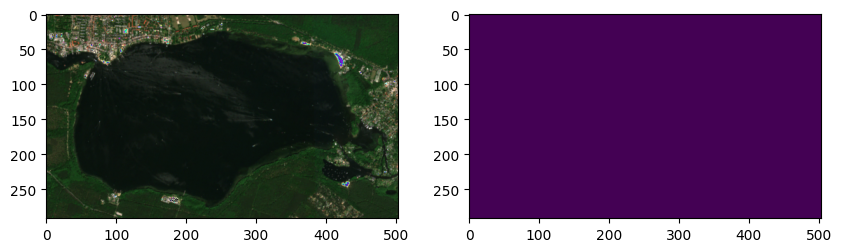

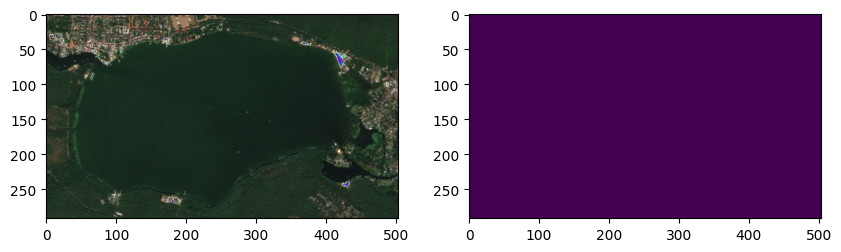

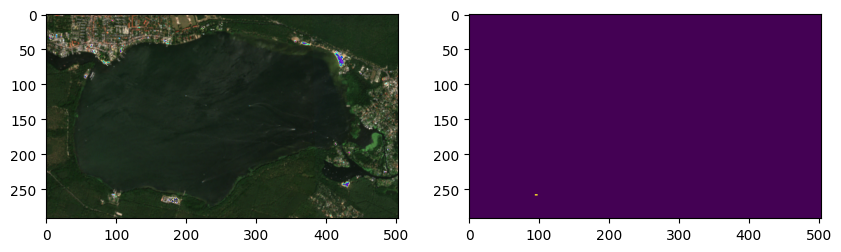

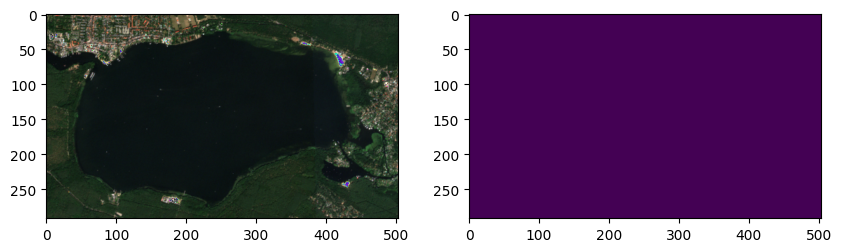

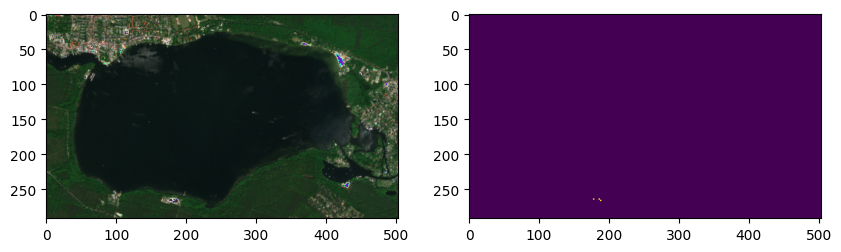

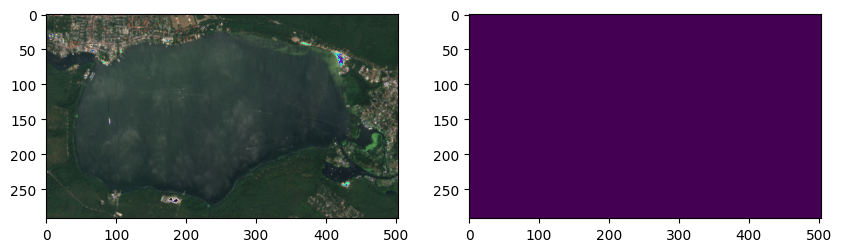

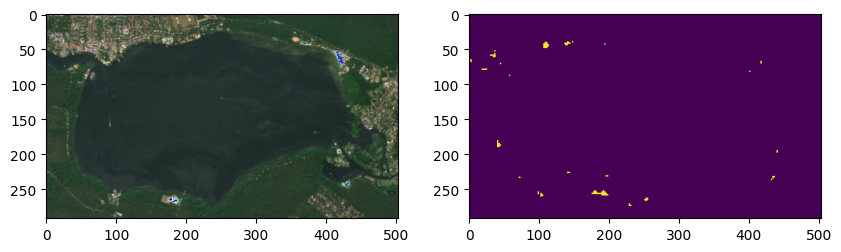

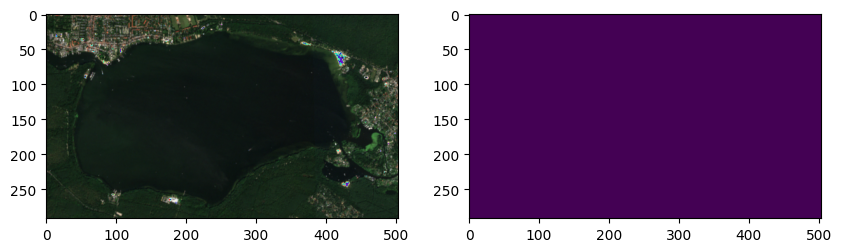

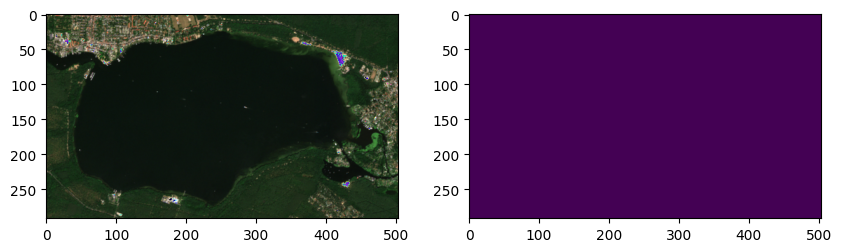

In [ ]:
for clouds, true_color in zip(clouds_per_year, true_color_per_year):
  fig, ax = plt.subplots(figsize = (10, 4), ncols = 2)
  ax[0].imshow(true_color * 2 / 255)
  ax[1].imshow(clouds[:, :, 1])

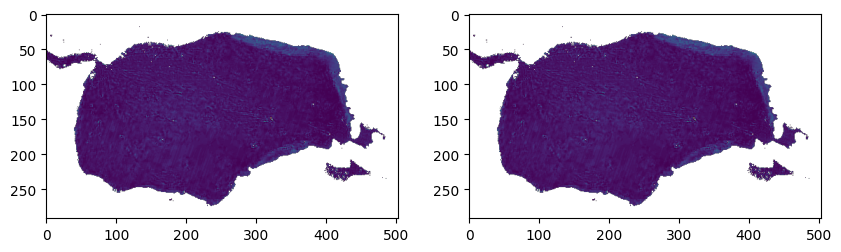

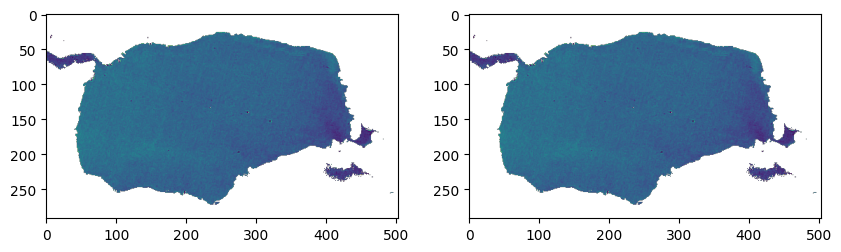

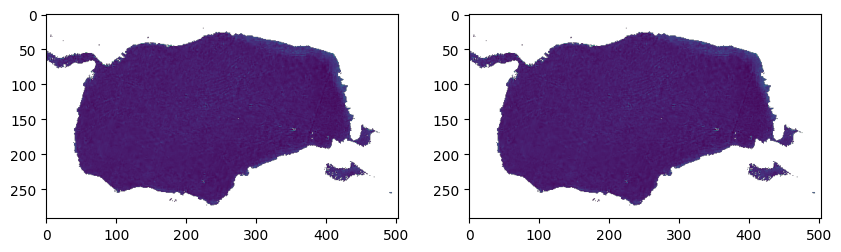

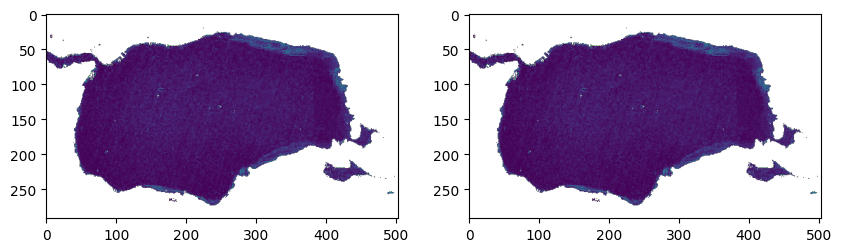

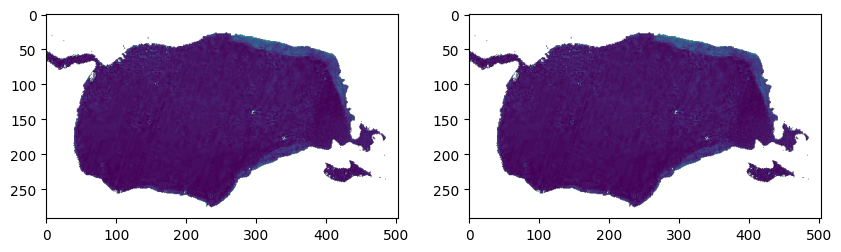

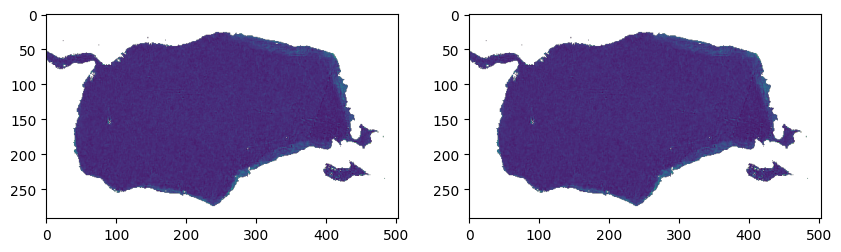

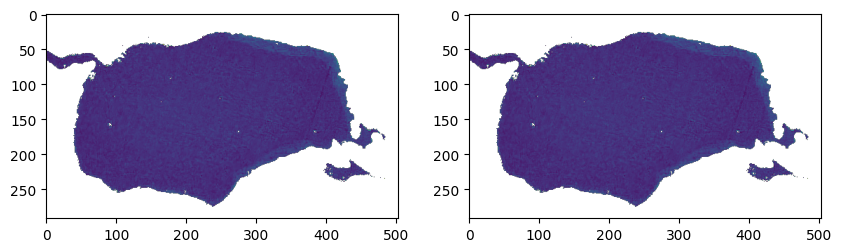

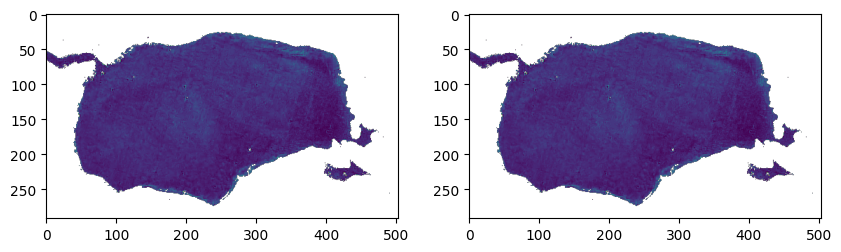

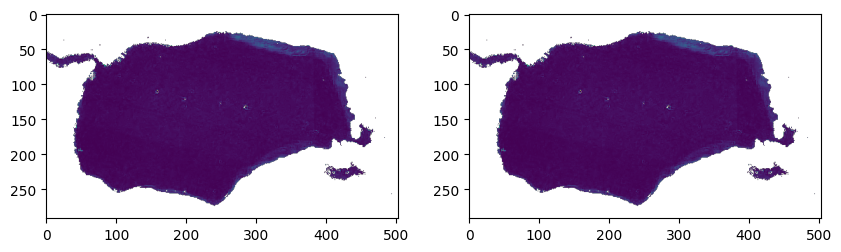

In [ ]:
metric_ind = 0

for clouds, water_im in zip(clouds_per_year, images_per_year):
  fig, ax = plt.subplots(figsize = (10, 4), ncols = 2)
  ax[0].imshow(water_im[:, :, metric_ind] * 2 / 255)
  ax[1].imshow(clouds[:, :, 0])
  #print(np.allclose(flat_dropna(water_im[:, :, 0]) - flat_dropna(clouds[:, :, 0]), 0))

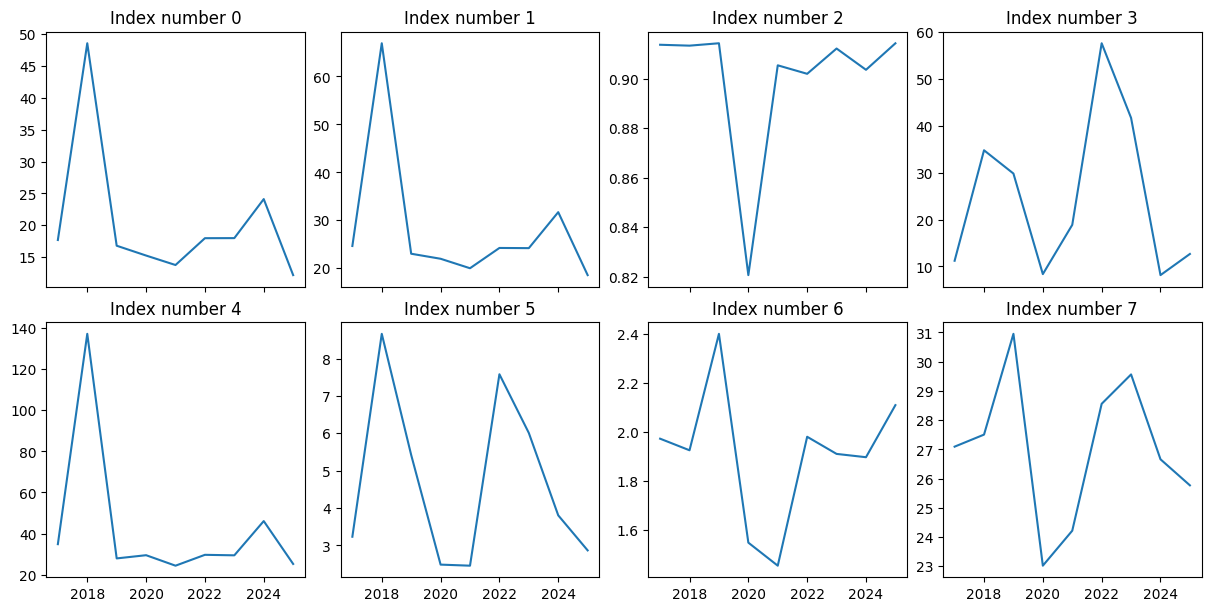

In [120]:
n_metrics = images_per_year[0].shape[-1]

fig, ax = plt.subplots(figsize = (12, 6), nrows = 2, ncols = (n_metrics - 1) // 2 + 1, constrained_layout = True, sharex = True)

for i in range(n_metrics):
  ax.flat[i].plot(year_list, [np.mean(flat_dropna(year_im[:, :, i])) for year_im in images_per_year])
  ax.flat[i].set_title(f"Index number {i}")

In [121]:
def nan_zero_normalize(arr):
  nn_arr = arr[np.isfinite(arr)]
  val_range = nn_arr.max() - nn_arr.min()
  norm_arr = (arr - nn_arr.min()) / val_range
  return norm_arr

norm_metric_ts_list = []
for i in range(n_metrics):
  arr = np.array([np.mean(flat_dropna(year_im[:, :, i])) for year_im in images_per_year])
  norm_arr = nan_zero_normalize(arr)
  norm_metric_ts_list.append(norm_arr)

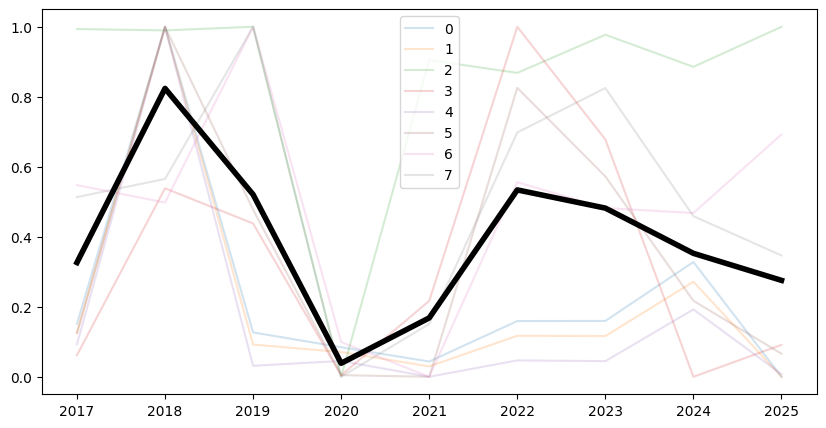

In [122]:
fig, ax = plt.subplots(figsize = (10, 5))

for i in range(n_metrics):
  ax.plot(year_list, norm_metric_ts_list[i], label = i, alpha = 0.2)

ax.plot(year_list, np.mean(np.stack(norm_metric_ts_list), axis=0), color = "black", lw = 4)

ax.legend()

# This summer only

In [ ]:
from datetime import date, timedelta

start = date(2025, 5, 1)
end = date(2025, 9, 1)
interval_length_in_days = 10

current_summer_intervals = []
current = start
while current < end:
    interval_end = current + timedelta(days=interval_length_in_days)
    current_summer_intervals.append((current.strftime("%Y-%m-%d"), interval_end.strftime("%Y-%m-%d")))
    current = interval_end

In [ ]:
one_summer_requests = []
for period in current_summer_intervals:
    req = SentinelHubRequest(
        evalscript=evalscript_all_metrics,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=period,
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            )
        ],
        responses=[
            SentinelHubRequest.output_response("default", MimeType.PNG),
            SentinelHubRequest.output_response("indices", MimeType.TIFF),
            SentinelHubRequest.output_response("eobrowserStats", MimeType.TIFF),
        ],
        bbox=aoi_bbox,
        size=aoi_size,
        config=config,
    )

    one_summer_requests.append(req)

In [ ]:
one_summer_responses = [request.get_data() for request in one_summer_requests]

In [ ]:
one_summer_images = [response[0]["indices.tif"] for response in one_summer_responses]
one_summer_true_color = [response[0]["default.png"] for response in one_summer_responses]
one_summer_clouds = [response[0]["eobrowserStats.tif"] for response in one_summer_responses]

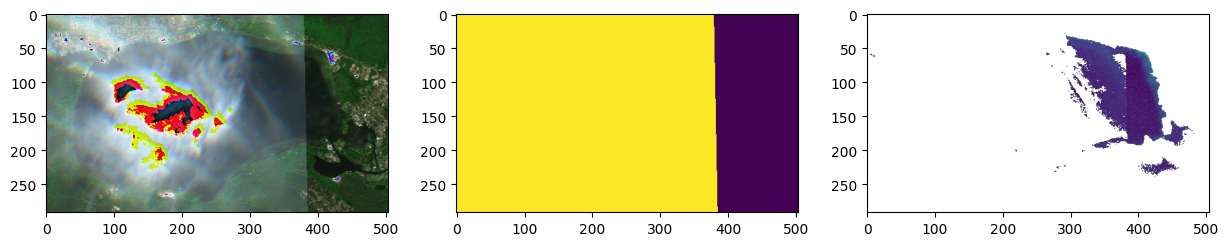

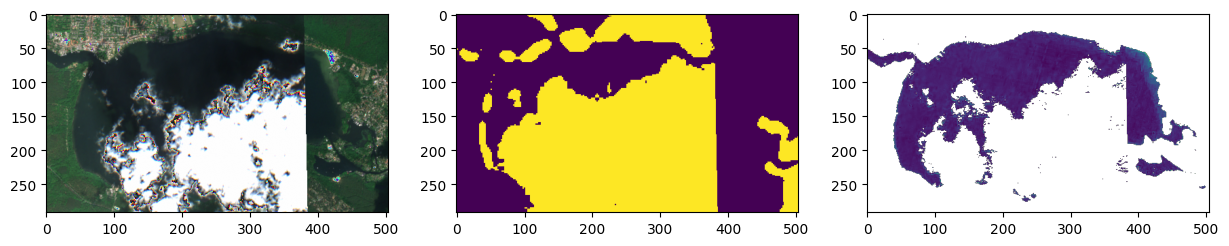

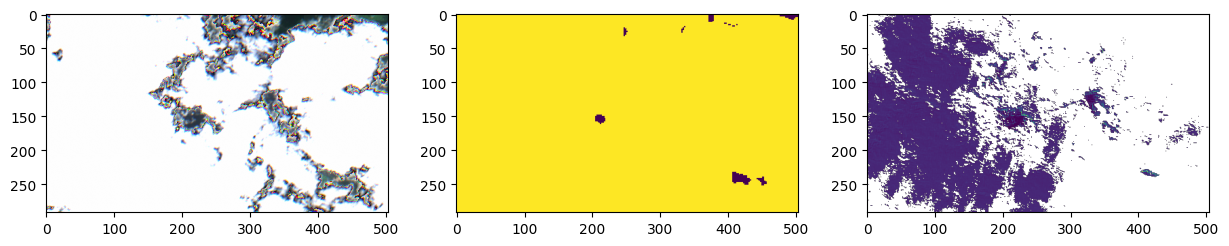

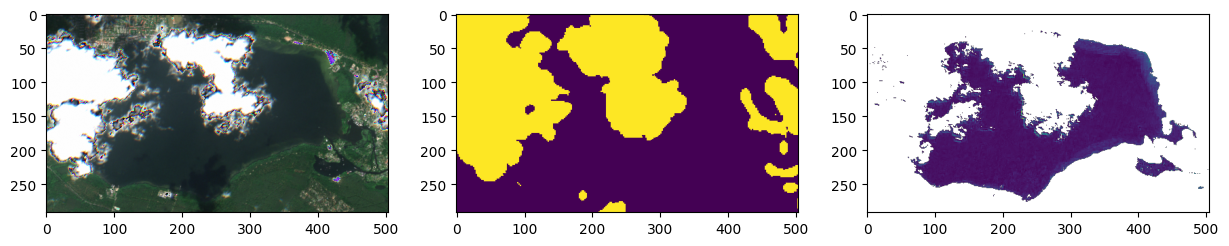

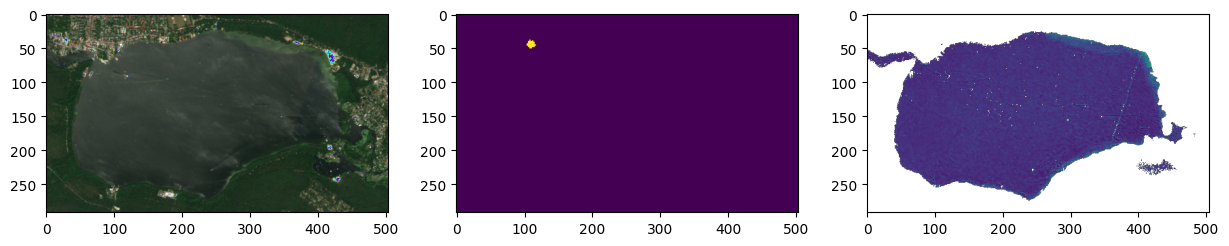

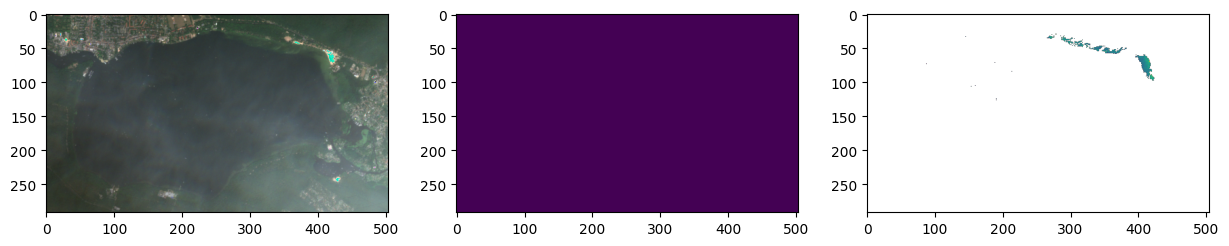

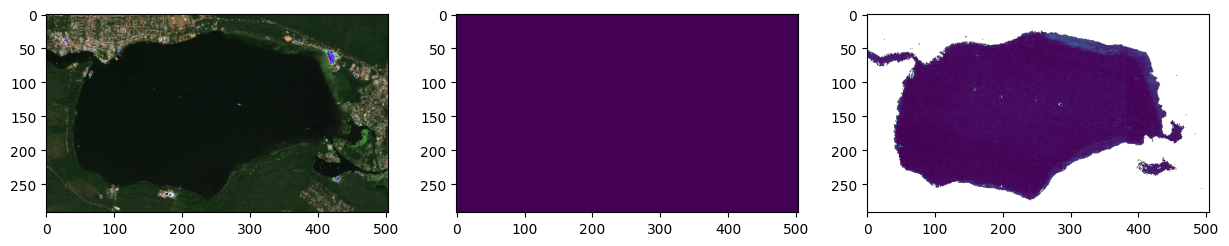

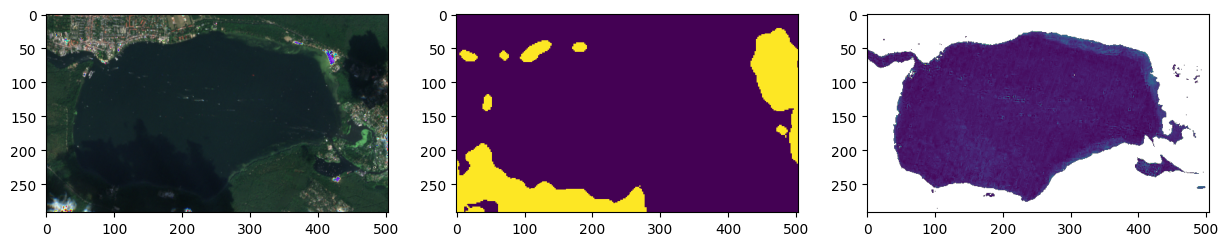

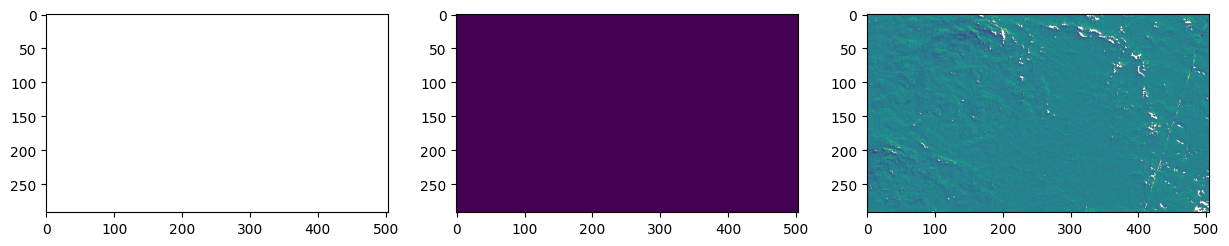

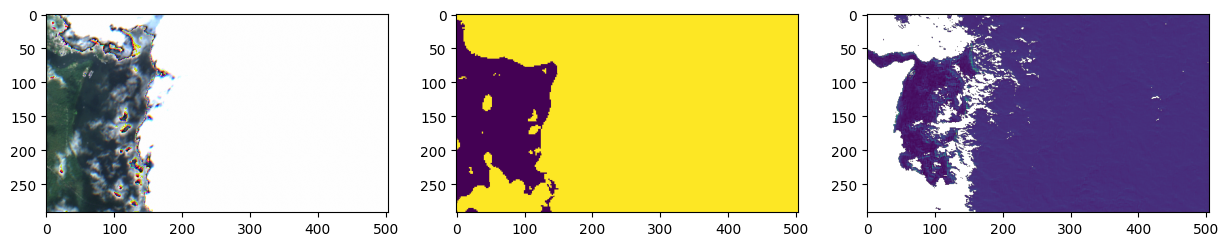

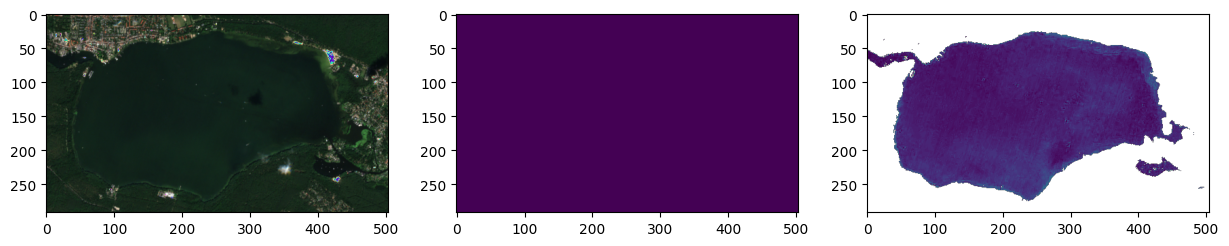

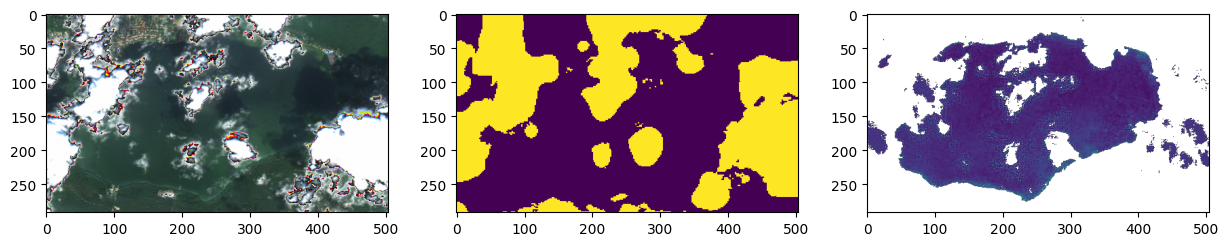

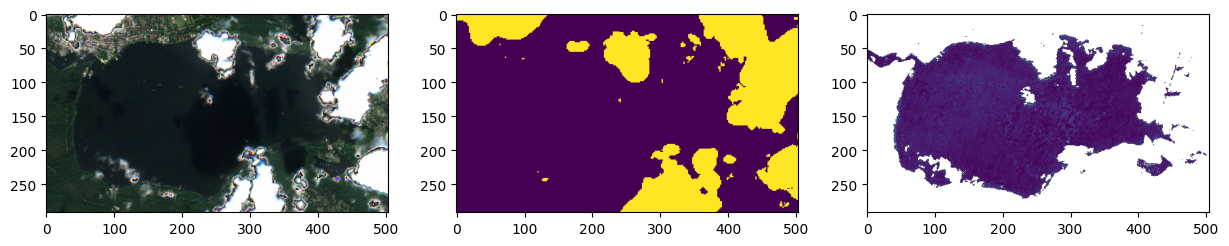

In [ ]:
for clouds, true_color in zip(one_summer_clouds, one_summer_true_color):
  fig, ax = plt.subplots(figsize = (15, 4), ncols = 3)
  ax[0].imshow(true_color * 2 / 255)
  ax[1].imshow(clouds[:, :, 1])
  ax[2].imshow(clouds[:, :, 0])

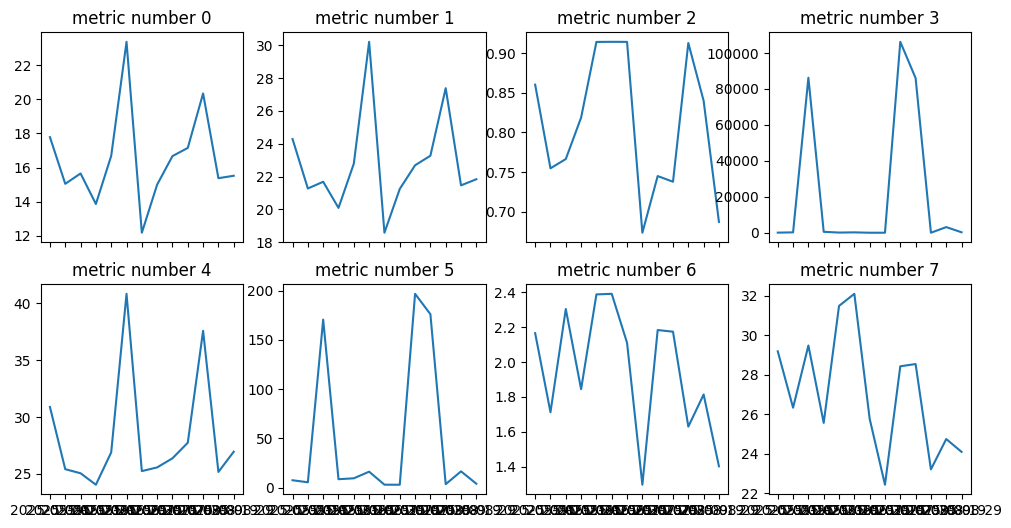

In [ ]:
start_dates = [tup[0] for tup in current_summer_intervals]

fig, ax = plt.subplots(figsize = (12, 6), ncols = (n_metrics - 1) // 2 + 1, nrows = 2, sharex = True)

for i in range(n_metrics):
  ax.flat[i].plot(
      start_dates,
      [np.mean(flat_dropna(year_im[:, :, i])) for year_im in one_summer_images]
      #[np.median(flat_dropna(year_im[:, :, i])) for year_im in one_summer_images]
  )
  ax.flat[i].set_title(f"metric number {i}")

In [ ]:
def normalize_arr(arr):
  nn_arr = arr[np.isfinite(arr)]
  val_range = nn_arr.max() - nn_arr.min()
  norm_arr = (arr - nn_arr.min()) / val_range
  return norm_arr

norm_one_summer_ts_list = []
for i in range(n_metrics):
  arr = np.array([np.mean(flat_dropna(year_im[:, :, i])) for year_im in one_summer_images])
  norm_one_summer_ts_list.append(normalize_arr(arr))

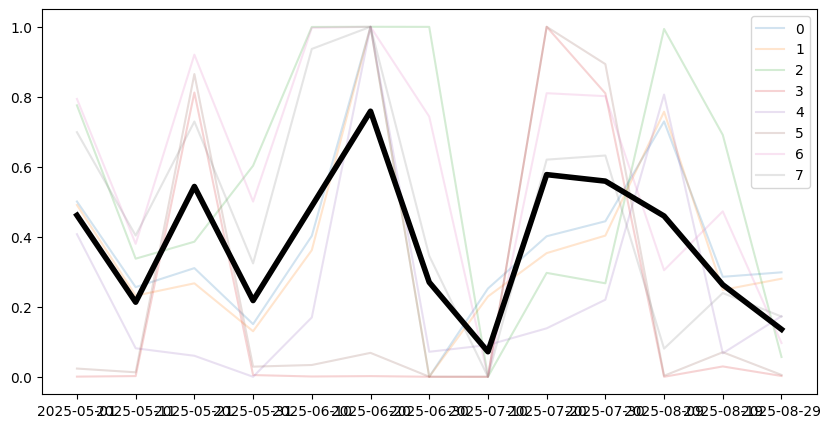

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))

for i in range(n_metrics):
  ax.plot(start_dates, norm_one_summer_ts_list[i], label = i, alpha = 0.2)

ax.plot(start_dates, np.mean(np.stack(norm_one_summer_ts_list), axis=0), color = "black", lw = 4)

ax.legend()

In [ ]:
#one_summer_true_color = [response[0]["default.png"] for response in one_summer_responses]
#
#for im in one_summer_true_color:
#  fig, ax = plt.subplots()
#  ax.imshow(im * 2.0/ 255.)
#  fig.show()

In [ ]:
!pip install meteostat

In [ ]:
from meteostat import Daily, Point

def berlin_temperatures(start_date: str, end_date: str, freq: str = "day", metric: str = "tavg"):
    """
    Return Berlin temperatures between start_date and end_date.

    Parameters
    ----------
    start_date : str
        Inclusive start date in 'YYYY-MM-DD' format.
    end_date : str
        Inclusive end date in 'YYYY-MM-DD' format.
    freq : str
        'day' for daily values, 'week' for weekly averages (ISO week: Mon–Sun).
    metric : str
        One of 'tavg' (mean), 'tmin', or 'tmax' in °C. If 'tavg' is missing,
        it falls back to (tmin + tmax) / 2 when available.

    Returns
    -------
    list[tuple[str, float]]
        List of (date_iso, temperature_c) pairs.
    """
    # Berlin city center
    berlin = Point(52.5200, 13.4050)

    # Parse dates
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    # Fetch daily data in local time
    #df = Daily(berlin, start, end, tz="Europe/Berlin").fetch()
    df = Daily(berlin, start, end).fetch()

    # Ensure we have a usable temperature column
    if metric not in {"tavg", "tmin", "tmax"}:
        raise ValueError("metric must be 'tavg', 'tmin', or 'tmax'")

    if metric == "tavg" and ("tavg" not in df.columns or df["tavg"].isna().all()):
        # Fallback: compute average from min/max if available
        if {"tmin", "tmax"}.issubset(df.columns):
            df["tavg"] = df[["tmin", "tmax"]].mean(axis=1)
        else:
            # If no tavg and cannot compute it, prefer tmax (or tmin) as last resort
            metric = "tmax" if "tmax" in df.columns else "tmin"

    # Keep only the chosen metric, drop missing
    out = df[[metric]].rename(columns={metric: "temp_c"}).dropna()

    # Aggregate if weekly requested (ISO-like weeks: Monday–Sunday)
    if freq.lower() == "week":
        # Resample to weekly mean with weeks ending on Sunday
        out = out.resample("W-SUN").mean()
    elif freq.lower() != "day":
        raise ValueError("freq must be 'day' or 'week'")

    # Return list of (date_iso, temperature_c)
    return [(idx.date().isoformat(), float(val)) for idx, val in out["temp_c"].items()]


In [ ]:
daily_temp = berlin_temperatures("2025-05-01", "2025-09-01", freq="day",  metric="tmax")

<Axes: >

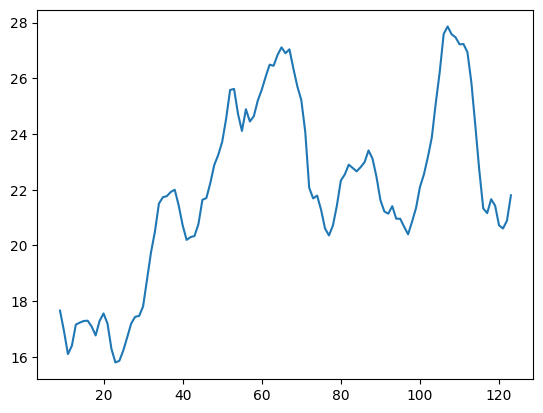

In [ ]:
daily_temp_df = pd.DataFrame(daily_temp, columns = ("date", "temp"))
daily_temp_df["temp"].rolling(10).mean().plot()

# Let's look at another lake (!! Krumme Lanke instead of Parsteiner... !!)

In [ ]:
#parsteiner_see_coords = [13.917446,52.884567,14.035034,52.955981]
parsteiner_see_coords = [13.227561,52.447169,13.241315,52.455787]

parsteiner_see_box = BBox(bbox=parsteiner_see_coords, crs=CRS.WGS84)
parsteiner_see_size = bbox_to_dimensions(parsteiner_see_box, resolution=resolution)

In [ ]:
parsteiner_summer_requests = []
for period in current_summer_intervals:
    req = SentinelHubRequest(
        evalscript=evalscript_all_metrics,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=period,
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
            )
        ],
        responses=[
            SentinelHubRequest.output_response("default", MimeType.PNG),
            SentinelHubRequest.output_response("indices", MimeType.TIFF),
        ],
        bbox=parsteiner_see_box,
        size=parsteiner_see_size,
        config=config,
    )

    parsteiner_summer_requests.append(req)

In [ ]:
parsteiner_summer_responses = [request.get_data() for request in parsteiner_summer_requests]

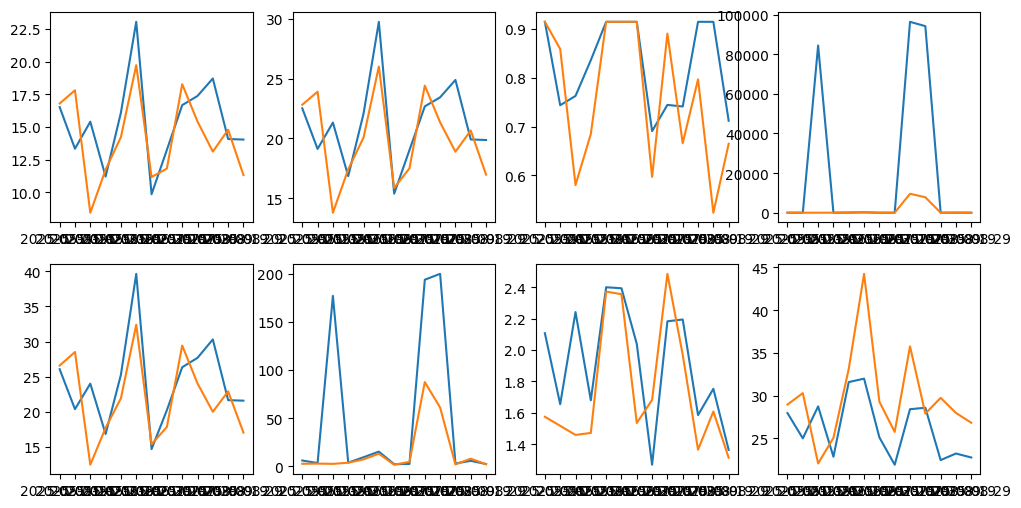

In [ ]:
parsteiner_summer_images = [response[0]["indices.tif"] for response in parsteiner_summer_responses]

fig, ax = plt.subplots(figsize = (12, 6), nrows = 2, ncols = (n_metrics - 1) // 2 + 1)

start_dates = [tup[0] for tup in current_summer_intervals]

#agg_fun = np.mean
agg_fun = np.median

for i in range(n_metrics):
  ax.flat[i].plot(
      start_dates,
      [agg_fun(flat_dropna(year_im[:, :, i])) for year_im in one_summer_images],
      label = "Muggelsee",
  )
  ax.flat[i].plot(
      start_dates,
      [agg_fun(flat_dropna(year_im[:, :, i])) for year_im in parsteiner_summer_images],
      label = "Parsteiner See",
  )

In [ ]:
norm_parsteiner_summer_ts_list = []
for i in range(n_metrics):
  arr = np.array([agg_fun(flat_dropna(year_im[:, :, i])) for year_im in parsteiner_summer_images])
  norm_parsteiner_summer_ts_list.append(normalize_arr(arr))

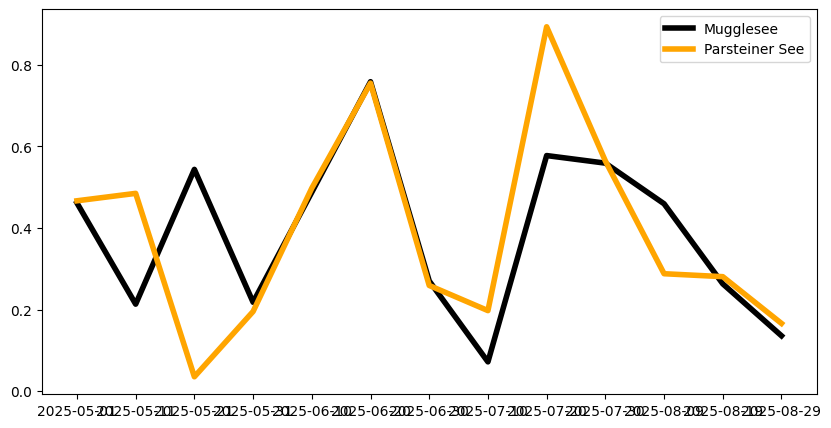

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(start_dates, np.mean(np.stack(norm_one_summer_ts_list), axis=0), color = "black", lw = 4, label = "Mugglesee")
ax.plot(start_dates, np.mean(np.stack(norm_parsteiner_summer_ts_list), axis=0), color = "orange", lw = 4, label = "Parsteiner See")

ax.legend()

In [ ]:
from datetime import datetime

def to_date(date_str: str):
  return datetime.strptime(date_str, "%Y-%m-%d").date()

## only selected indices

<Axes: xlabel='date'>

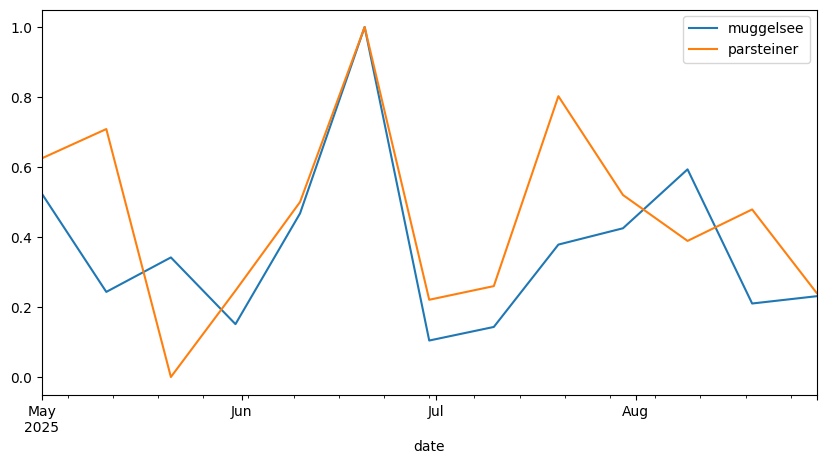

In [ ]:
indices_to_average = np.array([0, 1, 4, 7])

fig, ax = plt.subplots(figsize = (10, 5))

norm_df = pd.DataFrame(
    {
        "date" : [pd.to_datetime(sd) for sd in start_dates],
        "muggelsee": np.mean(np.stack(norm_one_summer_ts_list)[indices_to_average], axis=0),
        "parsteiner": np.mean(np.stack(norm_parsteiner_summer_ts_list)[indices_to_average], axis=0),
    }
)

norm_df.plot(x = "date", y = "muggelsee", ax=ax)
norm_df.plot(x = "date", y = "parsteiner", ax=ax)

with temperature data overlayed

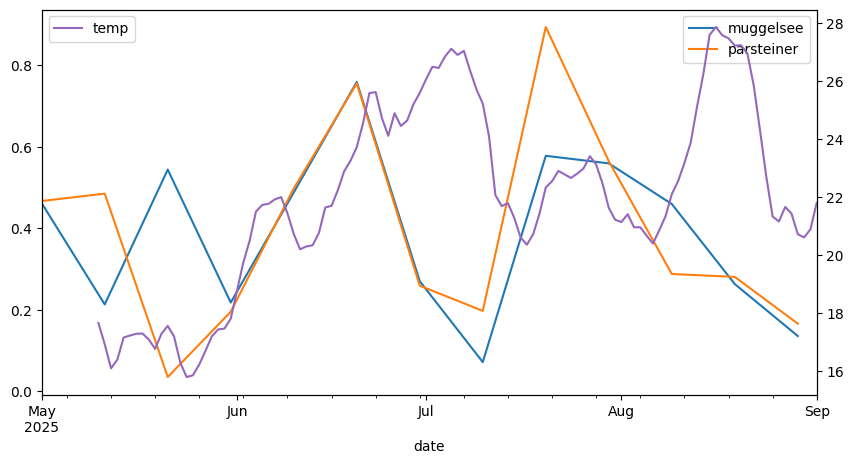

In [ ]:
#indices_to_average = np.array([0, 1, 4, 7])
indices_to_average = np.arange(0, 8)

fig, ax = plt.subplots(figsize = (10, 5))

norm_df = pd.DataFrame(
    {
        "date" : [pd.to_datetime(sd) for sd in start_dates],
        "muggelsee": np.mean(np.stack(norm_one_summer_ts_list)[indices_to_average], axis=0),
        "parsteiner": np.mean(np.stack(norm_parsteiner_summer_ts_list)[indices_to_average], axis=0),
    }
)

norm_df.plot(x = "date", y = "muggelsee", ax=ax)
norm_df.plot(x = "date", y = "parsteiner", ax=ax)

ax2 = ax.twinx()

daily_temp_df["date"] = [pd.to_datetime(d) for d in daily_temp_df["date"]]
daily_temp_df.set_index("date").rolling(10).mean().plot(ax = ax2, color = "tab:purple")

ax.legend()

In [ ]:
one_summer_true_col = [response[0]["default.png"] for response in one_summer_responses]

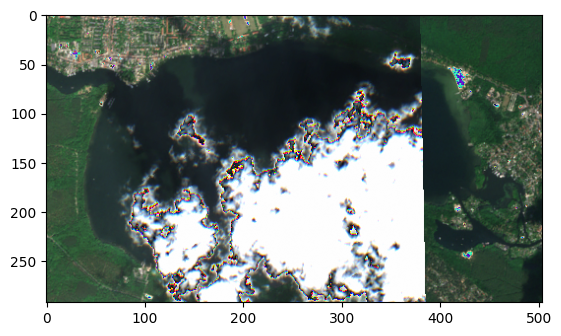

In [ ]:
plt.imshow(one_summer_true_col[1] * 2 / 255)

# Validating with measurements from some of Berlin's lakes this summer

In [ ]:
import pandas as pd

swim_df = pd.read_csv("https://www.data.lageso.de/baden/00_History_gesamt/History.csv", delimiter = ";")

In [ ]:
swim_df.head(10)

BadName  Prob_Datum  \
0                           Teufelssee  24.04.2025   
1                         Krumme Lanke  24.04.2025   
2                        Schlachtensee  24.04.2025   
3                    Sandhauser Straße  28.04.2025   
4                         Bürgerablage  28.04.2025   
5                 Tegeler See, Freibad  28.04.2025   
6  Tegeler See, gegenüber Scharfenberg  28.04.2025   
7    Tegeler See, gegenüber Reiswerder  28.04.2025   
8              Tegeler See, Saatwinkel  28.04.2025   
9            Tegeler See, Reiherwerder  28.04.2025   

  Escherichia coli<br> (KBE/ 100 ml)  \
0                                <15   
1                                234   
2                                 30   
3                                <15   
4                                <15   
5                                <15   
6                                <15   
7                                <15   
8                                 15   
9                                 15   

  Intestinale Enterokokken<br> (KBE/ 100 ml)  \
0                                        <15   
1                                        <15   
2                                         15   
3                                        <15   
4                                        <15   
5                                        <15   
6                                        <15   
7                                         15   
8                                         61   
9                                        <15   

  Coliforme Bakterien <br>(KBE/ 100 ml) Sichttiefe <br> (m)  \
0                                  <300                 > 1   
1                                   360                 > 1   
2                                  <300                 > 1   
3                                  <300                 1,2   
4                                  <300                 1,7   
5                                  <300               >1,90   
6                                  <300               >1,90   
7                                  <300               >1,30   
8                                  <300                 > 1   
9                                  <300                 > 1   

  Cyanobakterien Chl a <br>(µg/ l) Wassertemperatur <br> (°C)  \
0                                0                       14,8   
1                                0                       14,6   
2                                0                       14,3   
3                                0                       16,7   
4                              0,2                       16,2   
5                                0                       15,7   
6                                0                       15,5   
7                              0,1                       14,2   
8                              0,1                       14,2   
9                                0                       16,2   

  Aktuelle Warnhinweise                              Weitere Informationen  \
0                 keine                                              keine   
1                 keine                                              keine   
2                 keine                                              keine   
3                 keine                                              keine   
4                 keine                                              keine   
5                 keine  Wasserpflanzenansammlungen am Ufer meiden – kö...   
6                 keine  Wasserpflanzenansammlungen am Ufer meiden – kö...   
7                 keine  Wasserpflanzenansammlungen am Ufer meiden – kö...   
8                 keine  Wasserpflanzenansammlungen am Ufer meiden – kö...   
9                 keine  Wasserpflanzenansammlungen am Ufer meiden – kö...   

   Farbe  
0  gruen  
1  gruen  
2  gruen  
3  gruen  
4  gruen  
5  gruen  
6  gruen  
7  gruen  
8  gruen  
9  gruen

In [ ]:
#swim_df_backup = swim_df.copy()
#swim_df = swim_df_backup.copy()

In [ ]:
import numpy as np

swim_df["lake"] = [name.split(",")[0] for name in swim_df.BadName]
swim_df["measurement_date"] = pd.to_datetime(swim_df.Prob_Datum)

ecoli_col = "Escherichia coli<br> (KBE/ 100 ml)"
ie_col = "Intestinale Enterokokken<br> (KBE/ 100 ml)"
coliforme_col = "Coliforme Bakterien <br>(KBE/ 100 ml)"
sichttiefe_col = "Sichttiefe <br> (m)"
cyano_col = "Cyanobakterien Chl a <br>(µg/ l)"

def _coliforme_map(s):
  if isinstance(s, float) and np.isnan(s):
    return np.nan

  if s.startswith("<"):
    return float(s[1:]) / 2
  if s == "n.a.":
    return np.nan

  return float(s)

def _sichttiefe_map(s):
  if isinstance(s, float) and np.isnan(s):
    return np.nan

  if s.startswith(">"):
    s = s[1:]
    s = s.replace(",", ".")
    return float(s) * 1.1

  if s.startswith("<"):
    s = s[1:]
    s = s.replace(",", ".")
    return float(s) * 0.9

  s = s.replace(",", ".")

  return float(s)

def _cyano_map(s):
  if isinstance(s, float) and np.isnan(s):
    return np.nan

  s = s.replace(",", ".")

  return float(s)

swim_df[ecoli_col] = [float(s[1:]) * 0.9 if s.startswith("<") else float(s) for s in swim_df[ecoli_col]]
swim_df[ie_col] = [float(s[1:]) * 0.9 if s.startswith("<") else float(s) for s in swim_df[ie_col]]
swim_df[coliforme_col] = [_coliforme_map(s) for s in swim_df[coliforme_col]]
swim_df[sichttiefe_col] = [_sichttiefe_map(s) for s in swim_df[sichttiefe_col]]
swim_df[cyano_col] = [_cyano_map(s) for s in swim_df[cyano_col]]

In [ ]:
swim_df.BadName.unique().shape
swim_df.shape
pd.to_datetime(swim_df.Prob_Datum)

0     2025-04-24
1     2025-04-24
2     2025-04-24
3     2025-04-28
4     2025-04-28
         ...    
417   2025-09-15
418   2025-09-15
419   2025-09-16
420   2025-09-16
421   2025-09-16
Name: Prob_Datum, Length: 422, dtype: datetime64[ns]

In [ ]:
lakes_of_interest = ["Teufelssee", "Schlachtensee", "Weißensee", "Müggelsee", "Plötzensee", "Krumme Lanke"]

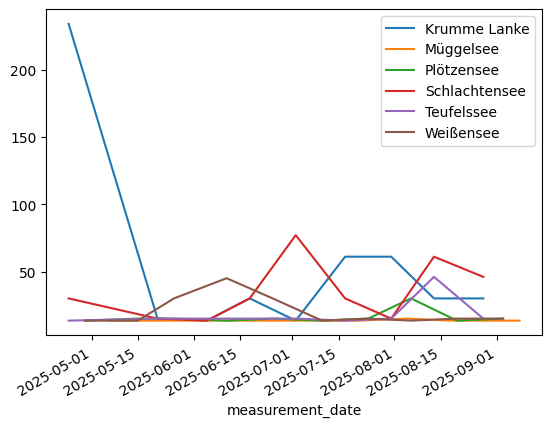

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for badname, subdf in swim_df.query("lake in @lakes_of_interest").groupby("lake"):
  plot_df = subdf.groupby("measurement_date")[ecoli_col].mean()
  plot_df.plot(x = "measurement_date", y = ecoli_col, label = badname, ax = ax)
ax.legend()

In [ ]:
muggel_df = swim_df.query("lake == 'Müggelsee'")
krumme_df = swim_df.query("lake == 'Krumme Lanke'")

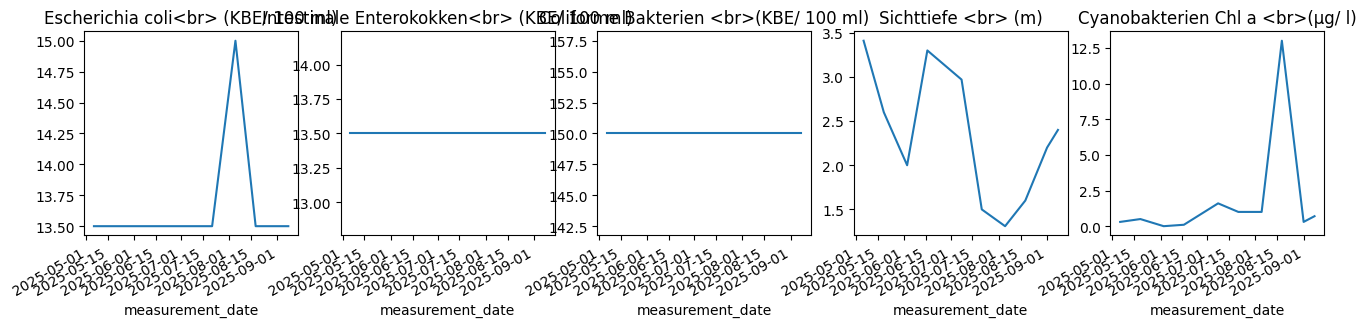

In [ ]:
fig, ax = plt.subplots(figsize = (16, 3), ncols = 5, sharex = True)

for i, colname in enumerate([ecoli_col, ie_col, coliforme_col, sichttiefe_col, cyano_col]):
  plot_df = muggel_df.groupby("measurement_date")[colname].mean()
  plot_df.plot(x = "measurement_date", y = colname,  ax = ax[i])
  ax[i].set_title(colname)

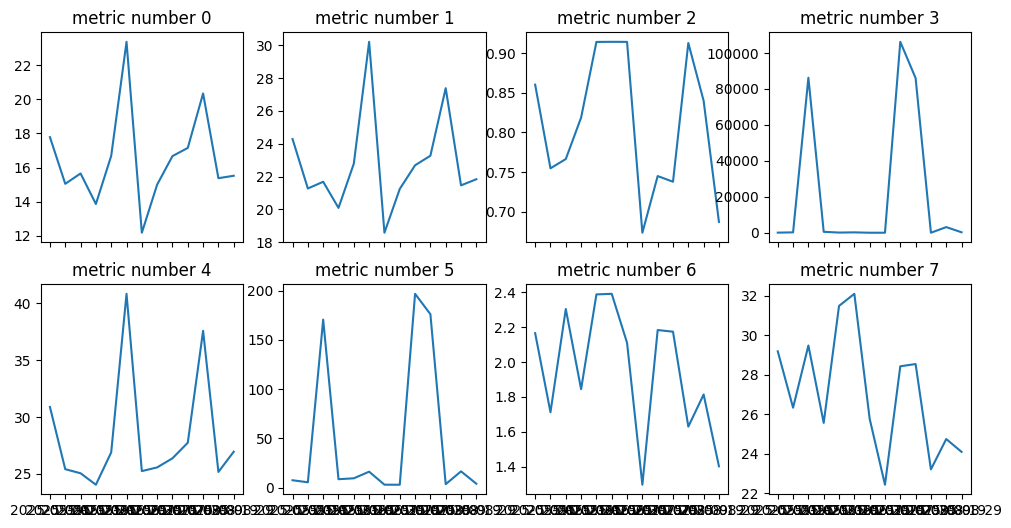

In [ ]:
start_dates = [tup[0] for tup in current_summer_intervals]

fig, ax = plt.subplots(figsize = (12, 6), ncols = (n_metrics - 1) // 2 + 1, nrows = 2, sharex = True)

for i in range(n_metrics):
  ax.flat[i].plot(
      start_dates,
      [np.mean(flat_dropna(year_im[:, :, i])) for year_im in one_summer_images]
      #[np.median(flat_dropna(year_im[:, :, i])) for year_im in one_summer_images]
  )
  ax.flat[i].set_title(f"metric number {i}")

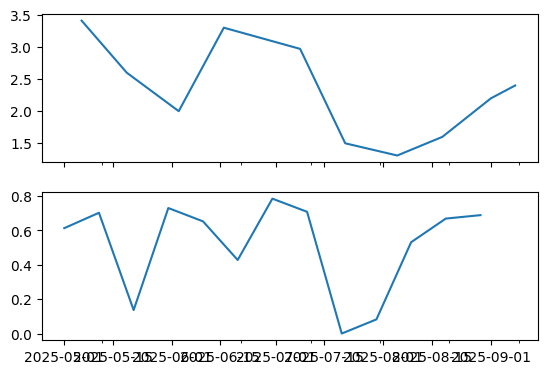

In [ ]:
fig, ax = plt.subplots(nrows = 2, sharex = True)
plot_df = muggel_df.groupby("measurement_date")[sichttiefe_col].mean()
plot_df.plot(x = "measurement_date", y = sichttiefe_col,  ax = ax[0])

# metric_ind = 3 # looks good
metric_ind = 5 # also good
#metric_ind = 1 # might be something there

metric_ts = np.array([np.mean(flat_dropna(year_im[:, :, metric_ind])) for year_im in one_summer_images])
#metric_ts = np.array([np.median(flat_dropna(year_im[:, :, metric_ind])) for year_im in one_summer_images])

#norms_to_include = np.array([3, 5, 1])
norms_to_include = np.array([3, 5, 1])
metric_ts = np.mean(np.stack(norm_one_summer_ts_list)[norms_to_include], axis=0)

ax[1].plot(
    pd.to_datetime(start_dates),
    metric_ts.max() - metric_ts,
    #metric_ts,
)

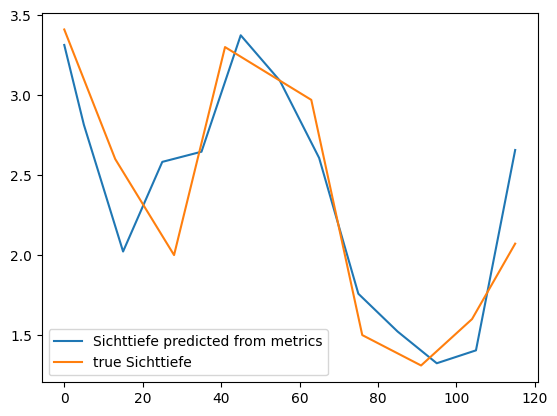

In [ ]:
from sklearn.linear_model import RidgeCV

norm_metric_df = pd.DataFrame(np.stack(norm_one_summer_ts_list).T, index = pd.to_datetime(start_dates))

X = norm_metric_df.resample("1D").mean().interpolate(method="time")
y = muggel_df.groupby("measurement_date")[sichttiefe_col].mean().resample("1D").mean().interpolate(method="time")
X, y = X.align(y, join="inner", axis=0)

ridge = RidgeCV(np.logspace(-4, 4)).fit(X, y)

plt.plot(ridge.predict(X), label = "Sichttiefe predicted from metrics")
plt.plot(y.values, label = "true Sichttiefe")
plt.legend()

quick control with shuffled data - bit worse

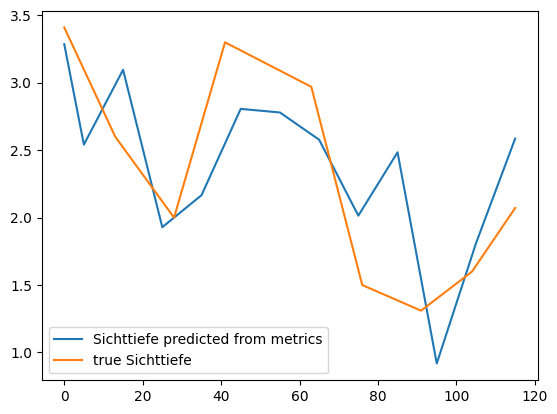

In [ ]:
from sklearn.linear_model import RidgeCV

_arr = np.stack(norm_one_summer_ts_list).T
shuffled_ind = np.arange(_arr.shape[0])
np.random.shuffle(shuffled_ind)

shuffled_norm_metric_df = pd.DataFrame(
    _arr[shuffled_ind, :],
    index = pd.to_datetime(start_dates)
)

X = shuffled_norm_metric_df.resample("1D").mean().interpolate(method="time")
y = muggel_df.groupby("measurement_date")[sichttiefe_col].mean().resample("1D").mean().interpolate(method="time")
X, y = X.align(y, join="inner", axis=0)

ridge = RidgeCV(np.logspace(-4, 4)).fit(X, y)

plt.plot(ridge.predict(X), label = "Sichttiefe predicted from metrics")
plt.plot(y.values, label = "true Sichttiefe")
plt.legend()

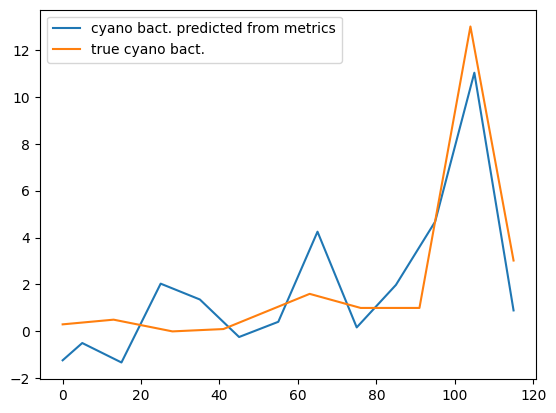

In [ ]:
norm_metric_df = pd.DataFrame(np.stack(norm_one_summer_ts_list).T, index = pd.to_datetime(start_dates))

X = norm_metric_df.resample("1D").mean().interpolate(method="time")
y = muggel_df.groupby("measurement_date")[cyano_col].mean().resample("1D").mean().interpolate(method="time")
X, y = X.align(y, join="inner", axis=0)

ridge = RidgeCV(np.logspace(-4, 4)).fit(X, y)

plt.plot(ridge.predict(X), label = "cyano bact. predicted from metrics")
plt.plot(y.values, label = "true cyano bact.")
plt.legend()

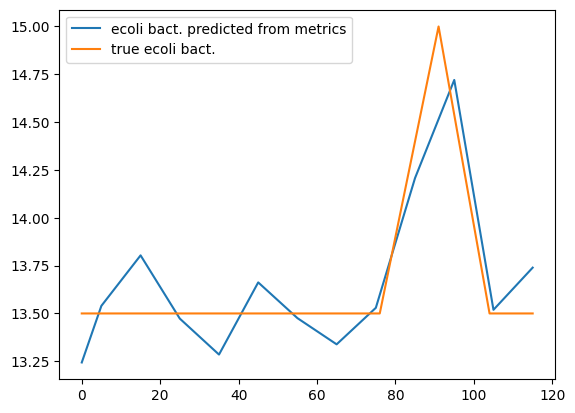

In [ ]:
norm_metric_df = pd.DataFrame(np.stack(norm_one_summer_ts_list).T, index = pd.to_datetime(start_dates))

X = norm_metric_df.resample("1D").mean().interpolate(method="time")
y = muggel_df.groupby("measurement_date")[ecoli_col].mean().resample("1D").mean().interpolate(method="time")
X, y = X.align(y, join="inner", axis=0)

ridge = RidgeCV(np.logspace(-4, 4)).fit(X, y)

plt.plot(ridge.predict(X), label = "ecoli bact. predicted from metrics")
plt.plot(y.values, label = "true ecoli bact.")
plt.legend()

Does it generalize from Muggelsee to Krumme Lanke?

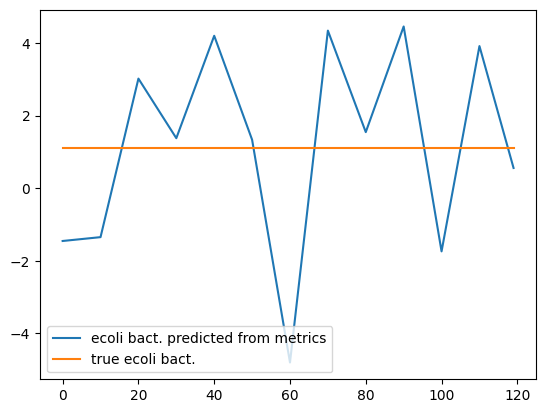

In [ ]:
norm_metric_df = pd.DataFrame(np.stack(norm_parsteiner_summer_ts_list).T, index = pd.to_datetime(start_dates))

X = norm_metric_df.resample("1D").mean().interpolate(method="time")
y = krumme_df.groupby("measurement_date")[sichttiefe_col].mean().resample("1D").mean().interpolate(method="time")
X, y = X.align(y, join="inner", axis=0)

plt.plot(ridge.predict(X), label = "ecoli bact. predicted from metrics")
plt.plot(y.values, label = "true ecoli bact.")
plt.legend()

not normalizing the metrics

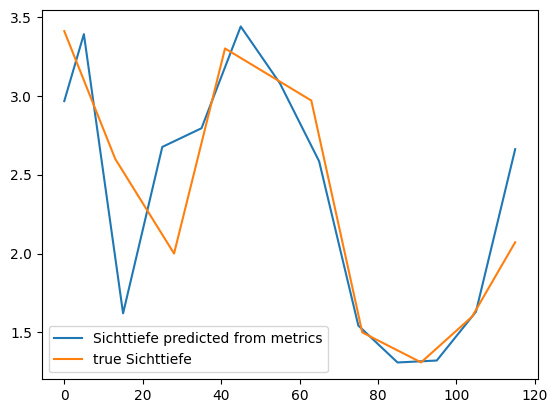

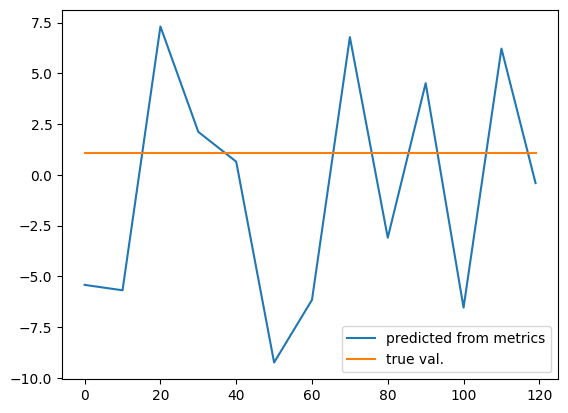

In [ ]:
metric_df = pd.DataFrame(
    np.stack([[agg_fun(flat_dropna(year_im[:, :, i])) for year_im in one_summer_images] for i in range(n_metrics)]).T,
    index = pd.to_datetime(start_dates)
)

X = metric_df.resample("1D").mean().interpolate(method="time")
y = muggel_df.groupby("measurement_date")[sichttiefe_col].mean().resample("1D").mean().interpolate(method="time")
X, y = X.align(y, join="inner", axis=0)

ridge = RidgeCV(np.logspace(-4, 4)).fit(X, y)

plt.figure()
plt.plot(ridge.predict(X), label = "Sichttiefe predicted from metrics")
plt.plot(y.values, label = "true Sichttiefe")
plt.legend()


krumme_metric_df = pd.DataFrame(
    np.stack([[agg_fun(flat_dropna(year_im[:, :, i])) for year_im in parsteiner_summer_images] for i in range(n_metrics)]).T,
    index = pd.to_datetime(start_dates)
)

X = krumme_metric_df.resample("1D").mean().interpolate(method="time")
y = krumme_df.groupby("measurement_date")[sichttiefe_col].mean().resample("1D").mean().interpolate(method="time")
X, y = X.align(y, join="inner", axis=0)

plt.figure()
plt.plot(ridge.predict(X), label = "predicted from metrics")
plt.plot(y.values, label = "true val.")
plt.legend()

In [ ]:
sorted(swim_df.lake.unique())

['Alter Hof',
 'Bammelecke',
 'Breitehorn',
 'Bürgerablage',
 'Dämeritzsee',
 'Flughafensee',
 'Friedrichshagen',
 'Gartenstraße',
 'Groß Glienicker See',
 'Große Krampe',
 'Große Steinlanke',
 'Grunewaldturm',
 'Grünau',
 'Halensee',
 'Heiligensee',
 'Jungfernheide',
 'Kleine Badewiese',
 'Kleiner Müggelsee',
 'Krumme Lanke',
 'Lieper Bucht',
 'Lübars',
 'Müggelsee',
 'Orankesee',
 'Plötzensee',
 'Radfahrerwiese',
 'Sandhauser Straße',
 'Schlachtensee',
 'Schmöckwitz',
 'Seddinsee',
 'Tegeler See',
 'Teufelssee',
 'Wannsee',
 'Weißensee',
 'Wendenschloss']

# Exported plots

In [86]:
import seaborn as sns

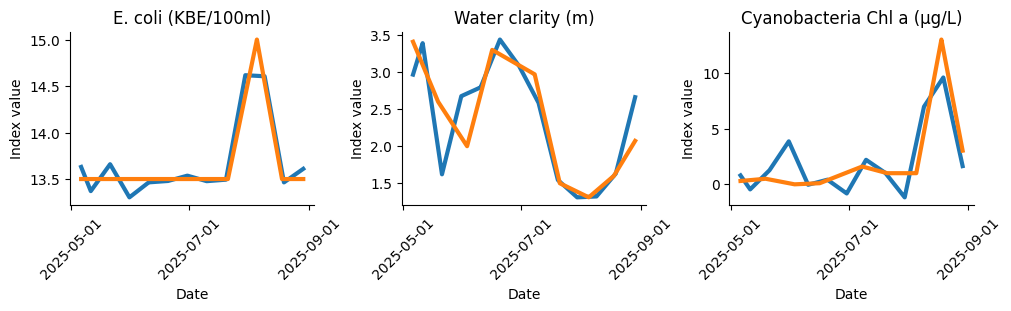

In [91]:
lw = 3

metric_df = pd.DataFrame(
    np.stack([[agg_fun(flat_dropna(year_im[:, :, i])) for year_im in one_summer_images] for i in range(n_metrics)]).T,
    index = pd.to_datetime(start_dates)
)

title_dict = {
    sichttiefe_col : "Water clarity (m)",
    ecoli_col : "E. coli (KBE/100ml)",
    #cyano_col : "Cyanobacteria chlorophyll a (µg/L)"
    cyano_col : "Cyanobacteria Chl a (µg/L)"
}

fig, ax = plt.subplots(figsize = (10, 3), ncols = 3, constrained_layout = True)

for i, colname in enumerate([ecoli_col, sichttiefe_col, cyano_col]):
  X = metric_df.resample("1D").mean().interpolate(method="time")
  y = muggel_df.groupby("measurement_date")[colname].mean().resample("1D").mean().interpolate(method="time")
  X, y = X.align(y, join="inner", axis=0)

  ridge = RidgeCV(np.logspace(-4, 4)).fit(X, y)

  time_axis = X.index

  ax[i].plot(time_axis, ridge.predict(X), label = "predicted from metrics", lw = lw)
  ax[i].plot(time_axis, y.values, label = "measurement", lw = lw)
  #ax[i].set_title(colname.replace("<br>", ""))
  ax[i].set_title(title_dict[colname])
  ax[i].set_xlabel("Date")
  ax[i].set_ylabel("Index value")

  ticks = ax[i].get_xticks()
  ax[i].set_xticks(ticks[::4])
  plt.setp(ax[i].get_xticklabels(), rotation=45)

  sns.despine()


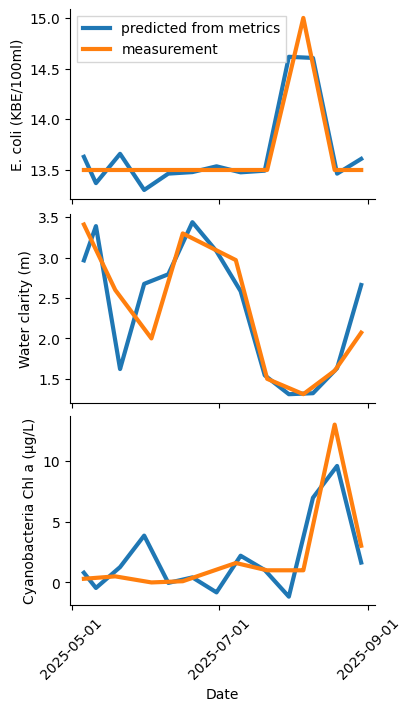

In [119]:
lw = 3

metric_df = pd.DataFrame(
    np.stack([[agg_fun(flat_dropna(year_im[:, :, i])) for year_im in one_summer_images] for i in range(n_metrics)]).T,
    index = pd.to_datetime(start_dates)
)

title_dict = {
    sichttiefe_col : "Water clarity (m)",
    ecoli_col : "E. coli (KBE/100ml)",
    #cyano_col : "Cyanobacteria chlorophyll a (µg/L)"
    cyano_col : "Cyanobacteria Chl a (µg/L)"
}

fig, ax = plt.subplots(figsize = (4, 7), nrows = 3, constrained_layout = True, sharex = True)

for i, colname in enumerate([ecoli_col, sichttiefe_col, cyano_col]):
  X = metric_df.resample("1D").mean().interpolate(method="time")
  y = muggel_df.groupby("measurement_date")[colname].mean().resample("1D").mean().interpolate(method="time")
  X, y = X.align(y, join="inner", axis=0)

  ridge = RidgeCV(np.logspace(-4, 4)).fit(X, y)

  time_axis = X.index

  ax[i].plot(time_axis, ridge.predict(X), label = "predicted from metrics", lw = lw)
  ax[i].plot(time_axis, y.values, label = "measurement", lw = lw)
  #ax[i].set_title(colname.replace("<br>", ""))
  #ax[i].set_title(title_dict[colname])
  ax[i].set_ylabel(title_dict[colname])

ax[0].legend(fancybox=False)

ax[-1].set_xlabel("Date")
ticks = ax[-1].get_xticks()
ax[-1].set_xticks(ticks[::4])
plt.setp(ax[-1].get_xticklabels(), rotation=45)

sns.despine()

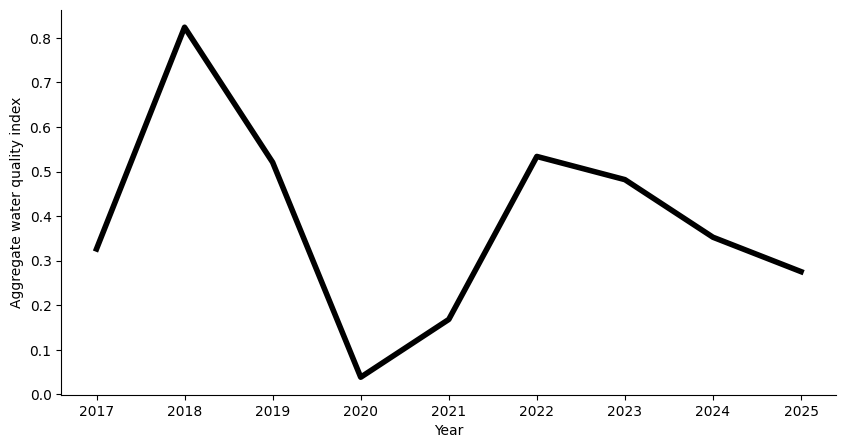

In [125]:
plot_individual_metrics = False

fig, ax = plt.subplots(figsize = (10, 5))

if plot_individual_metrics:
  for i in range(n_metrics):
    ax.plot(year_list, norm_metric_ts_list[i], label = i, alpha = 0.2)

ax.plot(year_list, np.mean(np.stack(norm_metric_ts_list), axis=0), color = "black", lw = 4)
ax.set_xlabel("Year")
ax.set_ylabel("Aggregate water quality index")
sns.despine()

fig.savefig("water_quality_by_year.png")

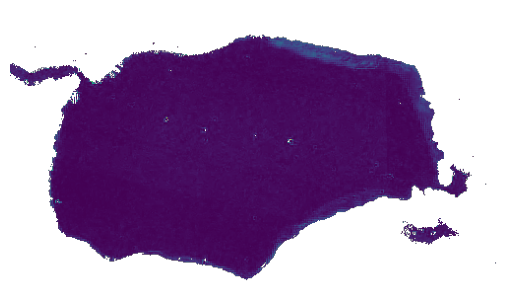

In [113]:
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots()

metric_ind = 0
frames = [_im[:, :, metric_ind] for _im in images_per_year]

im = ax.imshow(frames[0], cmap='viridis', animated=True)
ax.axis('off')

def update(frame):
    im.set_array(frame)
    return [im]

ani = FuncAnimation(
    fig, update, frames=frames, interval=1000, blit=True
)

ani.save('animation.mp4', writer='ffmpeg')

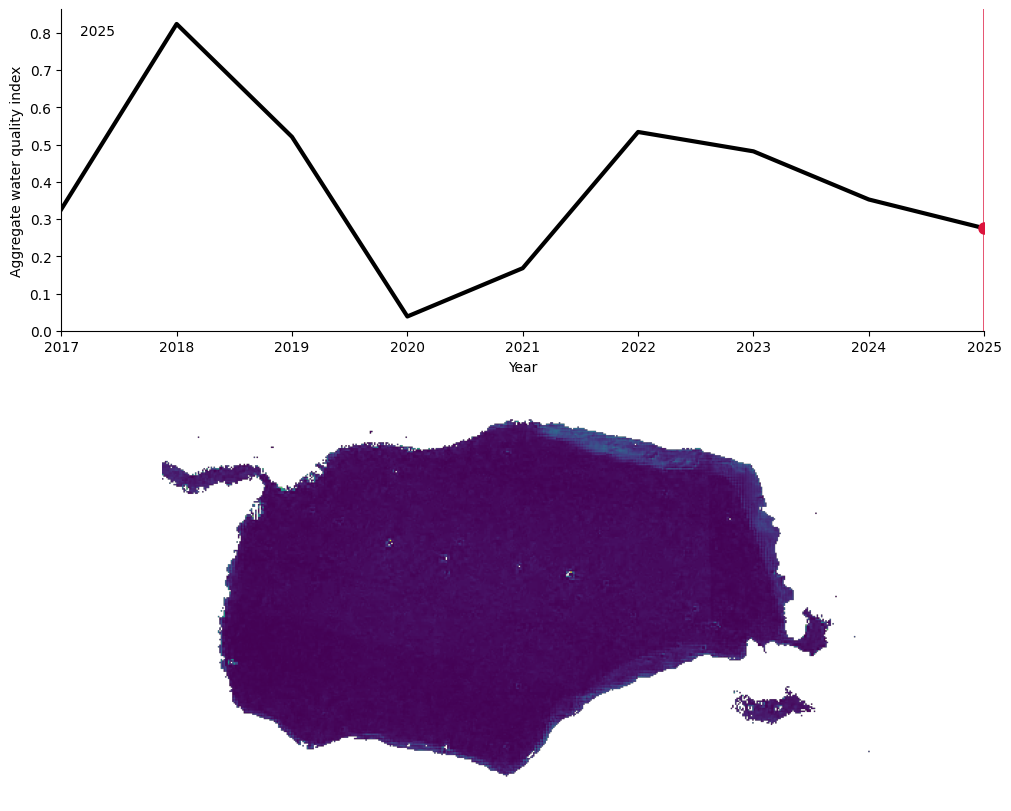

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- Data setup (assumes these already exist) ---
# year_list: list/1D array of years, length T
# norm_metric_ts_list: list of 1D arrays, each length T
# images_per_year: list/array of 3D images [H, W, n_metrics], length T
# metric_ind: which metric slice of the image to show (int)
T = len(year_list)
agg = np.mean(np.stack(norm_metric_ts_list), axis=0)  # aggregate line to show
frames = [im[:, :, metric_ind] for im in images_per_year]
assert len(frames) == T, "frames and year_list must have same length"

# --- Figure & axes: top=graph, bottom=image ---
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(10, 8),
    gridspec_kw={"height_ratios": [1.0, 1.3]},
    constrained_layout=True
)

# (Optional) plot individual series faintly
plot_individual_metrics = False
if plot_individual_metrics:
    for i, ts in enumerate(norm_metric_ts_list):
        ax_top.plot(year_list, ts, alpha=0.2)

# Main aggregate line
main_line, = ax_top.plot(year_list, agg, color="black", lw=3, zorder=1)

# Marker that highlights the current year on the line
vline = ax_top.axvline(year_list[0], color="crimson", lw=2, alpha=0.8)
dot,   = ax_top.plot([year_list[0]], [agg[0]], "o", ms=8, color="crimson", zorder=2)

ax_top.set_xlabel("Year")
ax_top.set_ylabel("Aggregate water quality index")
ax_top.set_xlim(min(year_list), max(year_list))
# optional: tight y-lims with a bit of padding
pad = 0.05 * (np.nanmax(agg) - np.nanmin(agg) + 1e-9)
ax_top.set_ylim(np.nanmin(agg) - pad, np.nanmax(agg) + pad)

# A small year label in the top plot (or put on bottom if you prefer)
year_text = ax_top.text(0.02, 0.92, f"{year_list[0]}", transform=ax_top.transAxes)

# Bottom image
im = ax_bot.imshow(frames[0], cmap="viridis", animated=True)
ax_bot.axis("off")
sns.despine(ax = ax_top)

# Make artists compatible with blitting
for artist in (vline, dot, year_text):
    artist.set_animated(True)

def update(i):
    # Update image
    im.set_array(frames[i])

    # Update line markers
    x = year_list[i]
    y = agg[i]
    vline.set_xdata([x])
    dot.set_data([x], [y])
    year_text.set_text(f"{x}")

    # Return all animated artists
    return [im, vline, dot, year_text]

ani = FuncAnimation(
    fig, update, frames=range(T), interval=1000, blit=True
)

# If you want a borderless saved video, consider pad/bbox args in savefig via savefig_kwargs.
ani.save("animation.mp4", writer="ffmpeg", dpi=120)

In [126]:
ndvi = pd.read_csv("ndvi.csv")

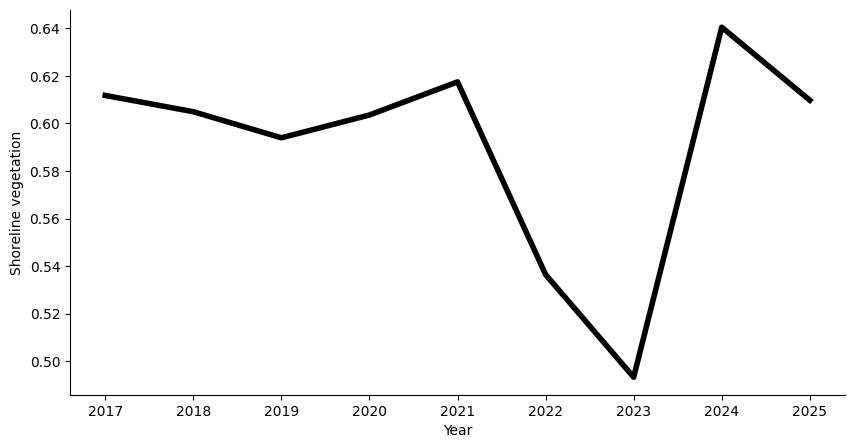

In [130]:
fig, ax = plt.subplots(figsize = (10, 5))

ax.plot(ndvi["years"], ndvi["mean"], lw = 4, color = "black")
ax.set_xlabel("Year")
ax.set_ylabel("Shoreline vegetation")
sns.despine()

fig.savefig("vegetation_by_year.png")
